In [1]:
import pickle
from misc import *
import SYCLOP_env as syc
from RL_brain_b import DeepQNetwork


In [2]:
import cv2
import time

In [3]:
from mnist import MNIST

mnist = MNIST('/home/bnapp/datasets/mnist/')
images, labels = mnist.load_training()
some_mnistSM =[ cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256)) for uu in images[:4096]]           
           


In [4]:
run_dir ='saved_runs/run_syclop_generic1.py_noname_1567934052/'

In [5]:
hp = HP()
hp.mem_depth=1
hp.logmode=False
batch_size=256
action_space_size=9
images = some_mnistSM

reward = syc.Rewards()
observation_size = 256*4
RL = DeepQNetwork(action_space_size, observation_size*hp.mem_depth,#sensor.frame_size+2,
                  reward_decay=0.99,
                  e_greedy=1-1e-9,
                  e_greedy0=1-1e-9,
                  replace_target_iter=10,
                  memory_size=100000,
                  e_greedy_increment=0.0001,
                  learning_rate=0.0025,
                  double_q=False,
                  dqn_mode=True,
                  state_table=np.zeros([1,observation_size*hp.mem_depth]),
                  soft_q_type='boltzmann',
                  beta=0.1
                  )




In [6]:

def local_observer(sensor,agent):
    if hp.logmode:
        normfactor=1.0
    else:
        normfactor = 1.0/256.0
    return normfactor*np.concatenate([relu_up_and_down(sensor.central_dvs_view),
            relu_up_and_down(cv2.resize(1.0*sensor.dvs_view, dsize=(16, 16), interpolation=cv2.INTER_AREA))])

observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])


In [7]:
scene_bb = [None]*batch_size
sensor_bb =[None]*batch_size
agent_bb = [None]*batch_size
action_bb = [None]*batch_size
action_list_bb =  [None]*batch_size
q_list_bb =  [None]*batch_size
observation_bb = [None]*batch_size
for bb in range(batch_size):
    scene_bb[bb] = syc.Scene(frame_list=images[0:1])
    sensor_bb[bb] = syc.Sensor()
    agent_bb[bb] = syc.Agent(max_q = [scene_bb[bb].maxx-sensor_bb[bb].hp.winx,scene_bb[bb].maxy-sensor_bb[bb].hp.winy])

In [8]:
result_type = 'best_liron.nwk'
RL.dqn.load_nwk_param(run_dir+'/'+ result_type) #tempX_1.nwk')
with open(run_dir+'/hp.pkl','rb') as f:
          this_hp = pickle.load(f)
          hp.fading_mem = this_hp.fading_mem +0.0 #to avoid assignment by address
            
action_records=[]
q_records=[]
observation_feeder=np.zeros([batch_size,1024])
for image_num,image in enumerate(images[:6000]):
    step = 0
    episode = 0
    for batch_num in range(len(images)//batch_size):
        for bb in range(batch_size):
            action_list_bb[bb] = []
    #         q_list_bb[bb] = []
            observation_bb[bb] = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
            observation_bb[bb] = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
    #         scene_bb[bb].current_frame = image_num[bb]
            scene_bb[bb].image = images[batch_num*batch_size+bb]

            agent_bb[bb].reset()
            agent_bb[bb].q_ana[1]=256./2.-32
            agent_bb[bb].q_ana[0]=256./2-32
            agent_bb[bb].q = np.int32(np.floor(agent_bb[bb].q_ana))

            sensor_bb[bb].reset()
            sensor_bb[bb].update(scene_bb[bb], agent_bb[bb])
            sensor_bb[bb].update(scene_bb[bb], agent_bb[bb])

        time1=time.time()
        for step_prime in range(1000):
            deep_time1=time.time()
    #         action = RL.choose_action(observation.reshape([-1]))
            for bb in range(batch_size):
                observation_feeder[bb,:]=observation_bb[bb].reshape([1,-1])
            oo = RL.dqn.eval(observation_feeder)        
            boltzmann_measure = np.exp(RL.beta * (oo-np.max(oo,axis=1).reshape([-1,1]))) #todo here substracted max to avoid exponent exploding. need to be taken into a separate function!
            boltzmann_measure = boltzmann_measure / np.sum(boltzmann_measure, axis=1).reshape([-1,1])
            for bb in range(batch_size):
                action_bb[bb] = np.random.choice(list(range(RL.n_actions)),1, p=boltzmann_measure[bb,:].reshape([-1]))[0]

    #         action_bb= [a for a in np.argmax(oo,axis=1)]
            deep_time2=time.time()
            shallow_time1=time.time()

            for bb in range(batch_size):
                agent_bb[bb].act(action_bb[bb])
                action_list_bb[bb].append(action_bb[bb])
    #             q_list_bb[bb].append(agent_bb[bb].q_ana)
                sensor_bb[bb].update(scene_bb[bb],agent_bb[bb])
                observation_bb[bb] *= hp.fading_mem
                observation_bb[bb] += local_observer(sensor_bb[bb], agent_bb[bb])  # todo: generalize
            shallow_time2=time.time()
    #         print('deep:',deep_time2-deep_time1,'shallow:',shallow_time2-shallow_time1)
        time2=time.time()

        print('batch num:',batch_num,'wall time consumed:',time2-time1)
        for bb in range(batch_size):
            action_records.append(action_list_bb[bb])
    #         q_records.append(q_list_bb[bb])


batch num: 0 wall time consumed: 39.37603545188904
batch num: 1 wall time consumed: 39.09826326370239
batch num: 2 wall time consumed: 38.909876346588135
batch num: 3 wall time consumed: 39.32987666130066
batch num: 4 wall time consumed: 40.11358571052551
batch num: 5 wall time consumed: 40.09310293197632
batch num: 6 wall time consumed: 39.46281933784485
batch num: 7 wall time consumed: 39.102954387664795
batch num: 8 wall time consumed: 39.24220681190491
batch num: 9 wall time consumed: 38.475791454315186
batch num: 10 wall time consumed: 38.28467679023743
batch num: 11 wall time consumed: 38.485058546066284
batch num: 12 wall time consumed: 38.345046281814575
batch num: 13 wall time consumed: 38.609906911849976
batch num: 14 wall time consumed: 38.3255352973938
batch num: 15 wall time consumed: 38.18565082550049


In [11]:
len(action_records)

4096

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook

IndexError: list index out of range

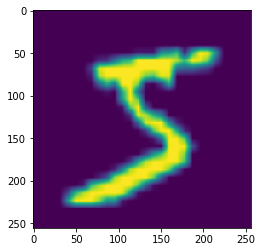

In [12]:
for ii,image in enumerate(images[:10]):
    plt.figure()
    plt.imshow(image)
    qq=np.array(q_records[ii]).transpose()
    plt.plot(32+qq[0],256-32-qq[1])

In [12]:
def freq(a):
    vals = sorted(set(a))
    freqs = {v:0 for v in vals}
    for q in a:
        freqs[q]+=1
    return np.array([freqs[q] for q in sorted(freqs.keys())])
def act_ent(a,epsilon=1e-20):
    f=freq(a)
    p=f/np.sum(f)
    return -np.sum(p*np.log2(p+epsilon))
    

In [15]:
ent_vec=[act_ent(aa) for aa in action_records]

(array([  51.,   84.,   87.,   90.,  117.,   94.,  109.,  138., 1458.,
        1868.]),
 array([0.11718782, 0.3827184 , 0.64824899, 0.91377957, 1.17931015,
        1.44484073, 1.71037132, 1.9759019 , 2.24143248, 2.50696307,
        2.77249365]),
 <a list of 10 Patch objects>)

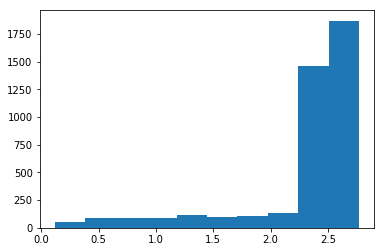

In [16]:
plt.figure()
plt.hist(ent_vec)

In [36]:
def prep_n_grams(x,n=None,offsets=None):
    if (n is None) and  not (offsets is None):
        pass
    elif not(n is None) and (offsets is None):
        offsets = list(range(n))
    else:
        error('need to provide either n or offsets')
    ngram_dict = {}
    for ii in range(len(x)-offsets[-1]):
        this_ngram = tuple(x[ii+oo] for oo in offsets)
        if this_ngram in ngram_dict.keys():
            ngram_dict[this_ngram] +=1
        else:
            ngram_dict[this_ngram] = 1
    return ngram_dict


In [37]:
ngrams=prep_n_grams(action_records[0],offsets=[0,3,6])

(array([101.,  24.,  11.,   4.,   2.,   5.,   0.,   1.,   2.,   0.,   0.,
          0.,   1.,   2.,   1.,   0.,   0.,   1.,   0.,   1.]),
 array([ 1. ,  4.3,  7.6, 10.9, 14.2, 17.5, 20.8, 24.1, 27.4, 30.7, 34. ,
        37.3, 40.6, 43.9, 47.2, 50.5, 53.8, 57.1, 60.4, 63.7, 67. ]),
 <a list of 20 Patch objects>)

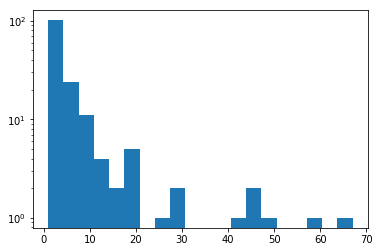

In [43]:
plt.hist([ii[-1] for ii in ngrams.items()],log=True,bins=20)

In [44]:
action_records_all = []
for uu in action_records:
    action_records_all += uu

In [45]:
ngrams_all=prep_n_grams(action_records_all,offsets=[0,3,6])

(0, 100000)

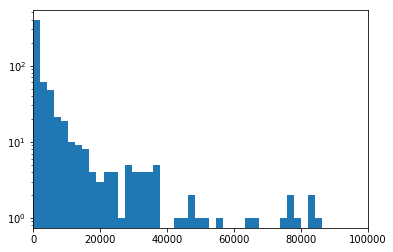

In [48]:
plt.hist([ii[-1] for ii in ngrams_all.items()],log=True,bins=300)
plt.xlim([0,100000])

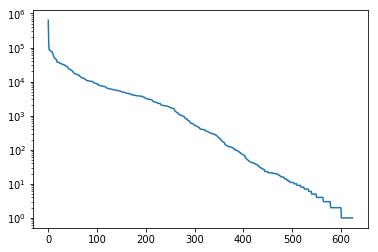

In [51]:
plt.semilogy(sorted([ii[-1] for ii in ngrams_all.items()],reverse=True))

In [69]:
mm=len(recorders)//40
for imag_num in range(mm):
#     plt.figure()
    for qq in range(40):
        if not qq%5:
            print('')
        recorder = recorders[mm*qq+imag_num]
        print("%2.2f   " % act_ent(recorder.records[-1]),end='')

    print('\n-----------------------------------------------------------')


0.17   2.43   1.38   0.64   1.39   
0.72   2.52   1.10   1.77   1.38   
0.48   1.41   2.15   2.22   1.93   
1.96   2.33   2.61   2.41   0.09   
0.04   1.75   1.59   0.99   0.12   
0.12   2.37   1.95   1.53   1.55   
0.42   2.32   2.12   2.41   1.72   
1.10   0.91   1.60   1.83   1.50   
-----------------------------------------------------------

0.02   1.63   1.51   1.57   1.56   
0.61   0.69   1.01   0.98   1.35   
1.30   2.20   2.20   2.28   2.24   
1.93   2.70   2.46   2.32   1.86   
0.03   1.79   1.02   0.92   0.47   
0.03   1.72   0.30   1.11   0.60   
1.44   2.14   1.57   2.63   1.52   
0.30   0.22   1.58   1.80   0.81   
-----------------------------------------------------------

0.02   1.87   0.81   1.18   1.01   
0.46   1.28   2.37   1.41   0.95   
0.68   1.58   2.23   2.03   2.21   
0.15   2.76   2.50   2.43   1.50   
-0.00   1.43   0.28   0.90   0.44   
0.08   2.32   0.70   0.93   1.36   
2.40   2.32   1.80   1.61   1.75   
1.41   2.21   2.09   1.52   1.49   
------------

In [73]:
mm=len(recorders)//40
ent_rec=np.zeros([mm,40])
for imag_num in range(mm):
#     plt.figure()
    for qq in range(40):
        recorder = recorders[mm*qq+imag_num]
        ent_rec[imag_num,qq]= act_ent(recorder.records[-1])

#     print('\n-----------------------------------------------------------')

In [71]:
mm

20

In [75]:
np.mean(ent_rec,axis=0).reshape([8,5])

array([[0.08867333, 1.61768941, 1.26392938, 1.06934454, 1.32479101],
       [0.56778131, 1.118531  , 1.40481863, 1.37234476, 0.99483986],
       [0.65041922, 1.10456292, 1.94771928, 2.08575282, 2.19934374],
       [1.01889872, 1.96847589, 2.30019204, 2.24871808, 1.12087346],
       [0.01799131, 1.57575043, 0.93726747, 0.97995684, 0.71790542],
       [0.06684287, 2.08576268, 1.1694828 , 1.14776738, 1.14449013],
       [0.80236751, 1.79133908, 1.78195371, 2.2334211 , 1.54591131],
       [0.53086538, 0.88911144, 1.88077619, 1.47832672, 1.21894077]])

In [77]:
np.std(ent_rec,axis=0).reshape([8,5])

array([[0.1075296 , 0.58613794, 0.32399309, 0.51226776, 0.36940398],
       [0.18299763, 0.55572623, 0.54100699, 0.3993687 , 0.3329549 ],
       [0.4479287 , 0.73012142, 0.51751262, 0.33841748, 0.38995168],
       [0.80926828, 0.91072015, 0.4862404 , 0.36071324, 0.6806439 ],
       [0.01196951, 0.37923138, 0.33740237, 0.35205962, 0.40461655],
       [0.04216233, 0.48016429, 0.39385541, 0.31457041, 0.34203969],
       [0.63991391, 0.68518811, 0.3361976 , 0.54030882, 0.38239973],
       [0.31184571, 0.66062811, 0.37916077, 0.45935426, 0.22073964]])

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


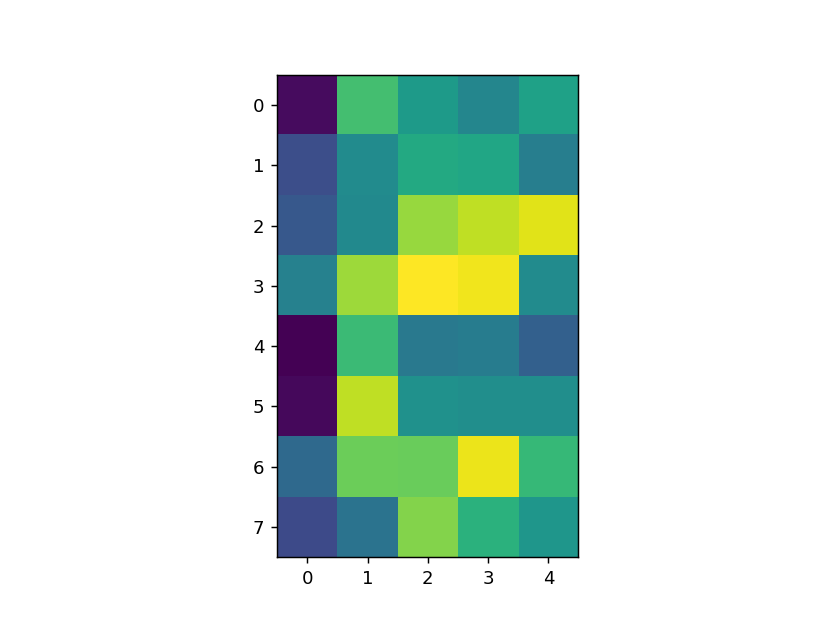

In [76]:
plt.figure()
plt.imshow(np.mean(ent_rec,axis=0).reshape([8,5]))

In [78]:
labels[:20]

array('B', [5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9])

In [80]:
labels[1]

0

In [81]:
len(labels)

60000

In [82]:
mm=len(recorders)//40
diff_rec=np.zeros([mm,40])
for imag_num in range(mm):
#     plt.figure()
    for qq in range(40):
        recorder = np.array(recorders[mm*qq+imag_num].records[-1])
        diff_rec[imag_num,qq]=np.mean(recorder[:-1]!=recorder[1:])

In [87]:
np.mean(diff_rec,axis=0).reshape([-1,5])

array([[0.01046046, 0.24654655, 0.23423423, 0.19164164, 0.19389389],
       [0.01781782, 0.10915916, 0.23413413, 0.21386386, 0.17472472],
       [0.06991992, 0.1525025 , 0.33808809, 0.36466466, 0.3998999 ],
       [0.19129129, 0.25335335, 0.32537538, 0.35385385, 0.1538038 ],
       [0.00225225, 0.30955956, 0.22992993, 0.21866867, 0.21846847],
       [0.0048048 , 0.36246246, 0.18133133, 0.25475475, 0.3548048 ],
       [0.07517518, 0.25855856, 0.26111111, 0.34474474, 0.26156156],
       [0.04344344, 0.09404404, 0.26976977, 0.20825826, 0.23878879]])

<IPython.core.display.Javascript object>


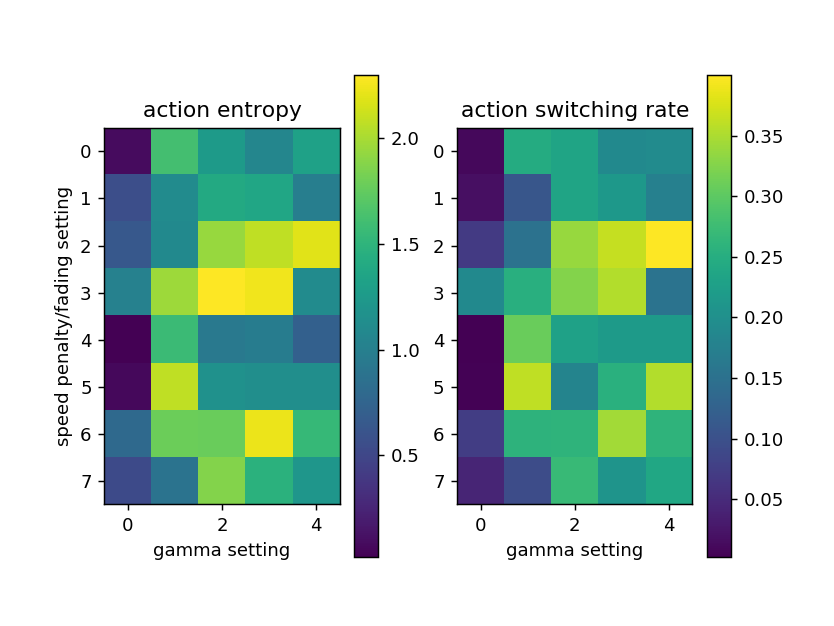

Text(0.5, 0, 'gamma setting')

In [94]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.mean(ent_rec,axis=0).reshape([8,5]))
plt.colorbar()
plt.title('action entropy')
plt.ylabel('speed penalty/fading setting')
plt.xlabel('gamma setting')
plt.subplot(1,2,2)
plt.imshow(np.mean(diff_rec,axis=0).reshape([-1,5]))
plt.colorbar()
plt.title('action switching rate')
plt.xlabel('gamma setting')



In [52]:
len(action_records)

4096

In [53]:
len(labels)

60000

In [13]:
with open('mnist_temp_act_boltzmann101.pkl','wb') as f:
    pickle.dump([action_records,labels[:len(action_records)]],f)

In [55]:
labels[:len(action_records)]

array('B', [5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5, 9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7, 9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9, 6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6, 8, 7, 6, 0, 9, 7, 5, 7, 2, 1, 1, 6, 8, 9, 4, 1, 5, 2, 2, 9, 0, 3, 9, 6, 7, 2, 0, 3, 5, 4